<a href="https://colab.research.google.com/github/xy2119/Data_Mining/blob/main/Recommender_System/GAE_VGAE_Cora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!git clone https://github.com/dmlc/dgl.git
!pip install dgl
!pip install --upgrade gensim
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [ ]:
import pandas as pd
import numpy as np

import os.path as osp
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import random
random.seed(2022)
np.random.seed(2022)
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset[0]
print(dataset.data)

# use train_test_split_edges to create neg and positive edges
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)
print(data)

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[2708, 1433], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torch.autograd import Variable

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Variational Graph Auto-Encoder
class VGAE(nn.Module):
   def __init__(self, **kwargs):
      super(VGAE, self).__init__()
      
      self.num_neurons = kwargs['num_neurons']
      self.num_features = kwargs['num_features']
      self.embedding_size = kwargs['embedding_size']
      
      self.w_0 = VGAE.random_uniform_init(self.num_features, self.num_neurons)
      self.b_0 = torch.nn.init.constant_(nn.Parameter(torch.Tensor(self.num_neurons)), 0.01)
      
      self.w_1_mu = VGAE.random_uniform_init(self.num_neurons, self.embedding_size)
      self.b_1_mu = torch.nn.init.constant_(nn.Parameter(torch.Tensor(self.embedding_size)), 0.01)

      self.w_1_sigma = VGAE.random_uniform_init(self.num_neurons, self.embedding_size)
      self.b_1_sigma = torch.nn.init.constant_(nn.Parameter(torch.Tensor(self.embedding_size)), 0.01)

      
   @staticmethod
   def random_uniform_init(input_dim, output_dim):
      
      init_range = np.sqrt(6.0/(input_dim + output_dim))
      tensor = torch.FloatTensor(input_dim, output_dim).uniform_(-init_range, init_range)
      
      return nn.Parameter(tensor)

   def encode(self, adjacency, norm_adj, x_features):
      
      hidden_0 = torch.relu(torch.add(torch.matmul(torch.matmul(norm_adj, x_features), self.w_0), self.b_0))
      self.GCN_mu = torch.add(torch.matmul(torch.matmul(norm_adj, hidden_0), self.w_1_mu), self.b_1_mu)
      self.GCN_sigma = torch.exp(torch.add(torch.matmul(torch.matmul(norm_adj, hidden_0), self.w_1_sigma), self.b_1_sigma))
      
      z = self.GCN_mu + torch.randn(self.GCN_sigma.size()) * self.GCN_sigma
      
      return z
   
   @staticmethod
   def decode(z):
      x_hat = torch.sigmoid(torch.matmul(z, z.t()))
      return x_hat


   def forward(self, adjacency, norm_adj, x_features):
      z = self.encode(adjacency, norm_adj, x_features)
      x_hat = VGAE.decode(z)
      
      return x_hat

In [ ]:
from dgl.nn.pytorch import GraphConv
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GAE,VGAE
#定义VGAEModel
class VGAEModel(nn.Module):
    def __init__(self, in_dim, hidden1_dim, hidden2_dim):#初始化VGAE
        super(VGAEModel, self).__init__()
        self.in_dim = in_dim#输入特征维度
        self.hidden1_dim = hidden1_dim#两个隐藏层维度
        self.hidden2_dim = hidden2_dim

        #三层GraphConv，原文中生成均值和方差的W0是共享的，W1是不同的，因此一共要三层
        #https://docs.dgl.ai/en/0.6.x/_modules/dgl/nn/pytorch/conv/graphconv.html
        #GraphConv用于实现GCN的卷积
        layers = [GraphConv(self.in_dim, self.hidden1_dim, activation=F.relu, allow_zero_in_degree=True),#第一层，共享参数
                  GraphConv(self.hidden1_dim, self.hidden2_dim, activation=lambda x: x, allow_zero_in_degree=True),#第二层求均值
                  GraphConv(self.hidden1_dim, self.hidden2_dim, activation=lambda x: x, allow_zero_in_degree=True)]#第二层求方差
        self.layers = nn.ModuleList(layers)

    def encoder(self, g, features):
        h = self.layers[0](g, features)#第一层得到输出h
        self.mean = self.layers[1](g, h)#第二层求均值
        self.log_std = self.layers[2](g, h)#第二层求方差
        gaussian_noise = torch.randn(features.size(0), self.hidden2_dim).to(device)#标准高斯分布采样，大小是features_size*hidden2_dim
        sampled_z = self.mean + gaussian_noise * torch.exp(self.log_std).to(device)#这里其实是reparameterization trick，具体看公式1和代码如何对应
        return sampled_z

    def decoder(self, z):
        adj_rec = torch.sigmoid(torch.matmul(z, z.t()))#解码器点乘还原邻接矩阵A'
        return adj_rec

    def forward(self, g, features):#前向传播
        z = self.encoder(g, features)#编码器得到隐变量
        adj_rec = self.decoder(z)#解码器还原邻接矩阵
        return adj_rec

class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)
        
class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
import dataclasses
out_channels = 1
num_features = 1433
epochs = 512

# model
model = GAE(GCNEncoder(num_features, out_channels)) # encoder: written by us; decoder: default (inner product)

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
# edge_weights=torch.ones(train_pos_edge_index.shape[1]).to(device)
# num_nodes=x.shape[0]

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

GAE

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encoder(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

for epoch in range(1, epochs + 1):
    loss = train()
    if epoch%25==0:
      auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
      print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

Epoch: 025, AUC: 0.7367, AP: 0.7495
Epoch: 050, AUC: 0.7368, AP: 0.7497
Epoch: 075, AUC: 0.7359, AP: 0.7509
Epoch: 100, AUC: 0.7359, AP: 0.7505
Epoch: 125, AUC: 0.7359, AP: 0.7492
Epoch: 150, AUC: 0.7351, AP: 0.7479
Epoch: 175, AUC: 0.7375, AP: 0.7502
Epoch: 200, AUC: 0.7367, AP: 0.7499
Epoch: 225, AUC: 0.7367, AP: 0.7499
Epoch: 250, AUC: 0.7371, AP: 0.7507
Epoch: 275, AUC: 0.7361, AP: 0.7497
Epoch: 300, AUC: 0.7357, AP: 0.7495
Epoch: 325, AUC: 0.7367, AP: 0.7511
Epoch: 350, AUC: 0.7375, AP: 0.7511
Epoch: 375, AUC: 0.7348, AP: 0.7480
Epoch: 400, AUC: 0.7349, AP: 0.7494
Epoch: 425, AUC: 0.7359, AP: 0.7501
Epoch: 450, AUC: 0.7353, AP: 0.7499
Epoch: 475, AUC: 0.7350, AP: 0.7493
Epoch: 500, AUC: 0.7358, AP: 0.7500


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


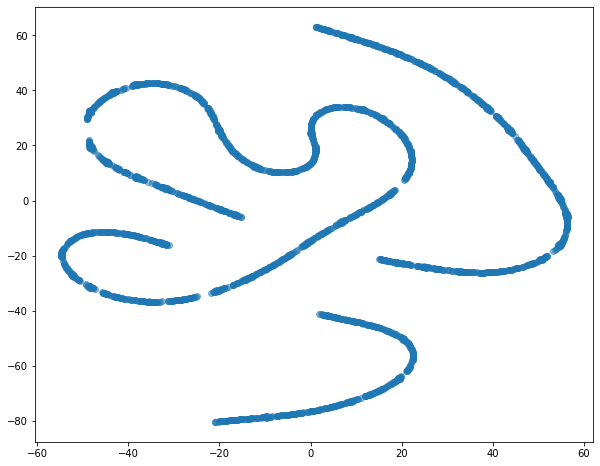

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
labels = data.y

model.eval()
z = model.encode(x, train_pos_edge_index)

xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.scatter(xs, ys, alpha=0.5)
plt.show()

VGAE

In [ ]:
out_channels = 1
num_features = 1433
epochs = 512
model = VGAE(VariationalGCNEncoder(num_features, out_channels))  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  
    loss.backward()
    optimizer.step()
    return float(loss)


for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))  

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

Epoch: 001, AUC: 0.6405, AP: 0.6732
Epoch: 002, AUC: 0.6665, AP: 0.6960
Epoch: 003, AUC: 0.6765, AP: 0.7038
Epoch: 004, AUC: 0.6808, AP: 0.7065
Epoch: 005, AUC: 0.6828, AP: 0.7078
Epoch: 006, AUC: 0.6837, AP: 0.7085
Epoch: 007, AUC: 0.6841, AP: 0.7086
Epoch: 008, AUC: 0.6846, AP: 0.7090
Epoch: 009, AUC: 0.6849, AP: 0.7092
Epoch: 010, AUC: 0.6851, AP: 0.7092
Epoch: 011, AUC: 0.6849, AP: 0.7091
Epoch: 012, AUC: 0.6848, AP: 0.7091
Epoch: 013, AUC: 0.6846, AP: 0.7089
Epoch: 014, AUC: 0.6844, AP: 0.7087
Epoch: 015, AUC: 0.6843, AP: 0.7085
Epoch: 016, AUC: 0.6841, AP: 0.7083
Epoch: 017, AUC: 0.6841, AP: 0.7084
Epoch: 018, AUC: 0.6840, AP: 0.7084
Epoch: 019, AUC: 0.6841, AP: 0.7085
Epoch: 020, AUC: 0.6843, AP: 0.7086
Epoch: 021, AUC: 0.6845, AP: 0.7088
Epoch: 022, AUC: 0.6848, AP: 0.7090
Epoch: 023, AUC: 0.6849, AP: 0.7092
Epoch: 024, AUC: 0.6853, AP: 0.7097
Epoch: 025, AUC: 0.6856, AP: 0.7100
Epoch: 026, AUC: 0.6860, AP: 0.7104
Epoch: 027, AUC: 0.6863, AP: 0.7107
Epoch: 028, AUC: 0.6866, AP:

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  
    loss.backward()
    optimizer.step()
    return float(loss)


for epoch in range(1, epochs + 1):
    loss = train()
    if epoch%25==0:
        auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
        print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))  

def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

Epoch: 025, AUC: 0.7440, AP: 0.7531
Epoch: 050, AUC: 0.7487, AP: 0.7587
Epoch: 075, AUC: 0.7463, AP: 0.7561
Epoch: 100, AUC: 0.7477, AP: 0.7585
Epoch: 125, AUC: 0.7460, AP: 0.7575
Epoch: 150, AUC: 0.7469, AP: 0.7580
Epoch: 175, AUC: 0.7457, AP: 0.7560
Epoch: 200, AUC: 0.7482, AP: 0.7583
Epoch: 225, AUC: 0.7473, AP: 0.7577
Epoch: 250, AUC: 0.7481, AP: 0.7579
Epoch: 275, AUC: 0.7457, AP: 0.7562
Epoch: 300, AUC: 0.7432, AP: 0.7521
Epoch: 325, AUC: 0.7462, AP: 0.7578
Epoch: 350, AUC: 0.7459, AP: 0.7584
Epoch: 375, AUC: 0.7483, AP: 0.7607
Epoch: 400, AUC: 0.7432, AP: 0.7553
Epoch: 425, AUC: 0.7460, AP: 0.7579
Epoch: 450, AUC: 0.7462, AP: 0.7587
Epoch: 475, AUC: 0.7434, AP: 0.7560
Epoch: 500, AUC: 0.7463, AP: 0.7591


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


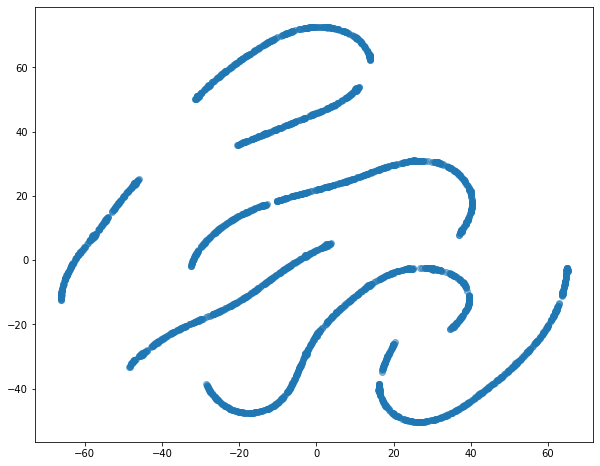

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
labels = data.y
#data.y = None
model.eval()
z = model.encode(x, train_pos_edge_index)


xs, ys = zip(*TSNE().fit_transform(z.cpu().detach().numpy()))

plt.figure(figsize=(10, 8))
plt.tight_layout()
plt.scatter(xs, ys, alpha=0.5)
plt.show()